In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from torch import nn
import torch
from PIL import Image
from torch.nn import functional as F

In [3]:
# content=Image.open('./datasets/content.jpg')
content=Image.open('./datasets/Tuebingen_Neckarfront.jpg')
style=Image.open('./datasets/style.jpg')

In [4]:
content=content.resize(style.size)

In [5]:
def to_float_tensor(item): return item.float().div_(255.)
def to_byte_tensor(item):
    res = torch.ByteTensor(torch.ByteStorage.from_buffer(item.tobytes()))
    w,h = item.size
    return res.view(h,w,-1).permute(2,0,1)

In [6]:
content=content.resize(content.size)
style=to_float_tensor(to_byte_tensor(style))
content=to_float_tensor(to_byte_tensor(content))

In [7]:
import matplotlib.pyplot as plt
def show_image(im, figsize=(10,10)):
    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.imshow(im.permute(1,2,0))

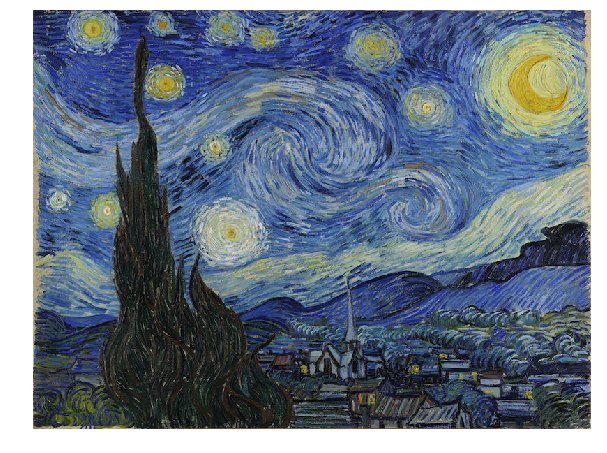

In [8]:
show_image(style)

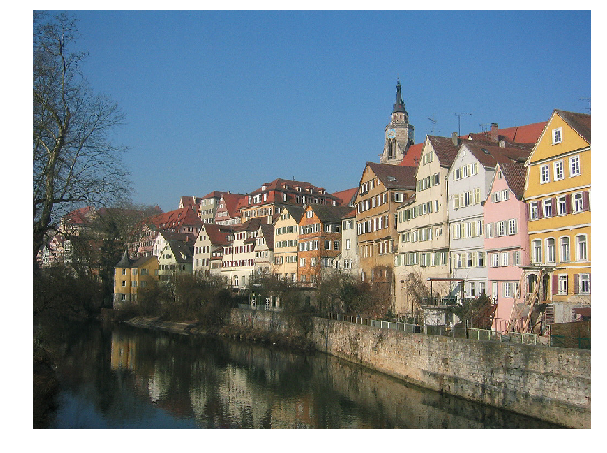

In [9]:
show_image(content)

In [10]:
def normalize_chan(x, mean, std):
    return (x-mean[...,None,None]) / std[...,None,None]

In [11]:
mean_c,std_c=content.mean([1,2]),content.std([1,2])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


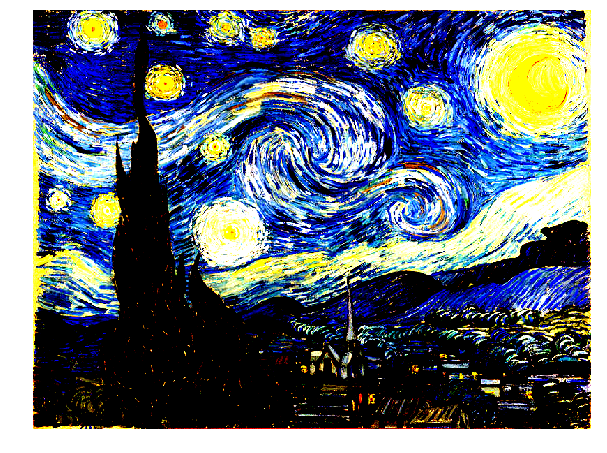

In [12]:
style=normalize_chan(style,style.mean([1,2]),style.std([1,2]))
content=normalize_chan(content,content.mean([1,2]),content.std([1,2]))
show_image(style)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


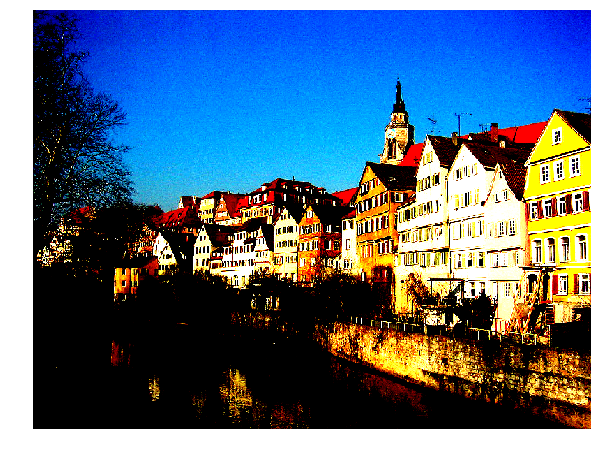

In [13]:
show_image(content)

In [14]:
style.shape,content.shape

(torch.Size([3, 600, 800]), torch.Size([3, 600, 800]))

In [15]:
# x=torch.nn.Parameter(torch.FloatTensor(content.shape))
x = torch.tensor(content, requires_grad=True, device='cuda')
# x = torch.tensor(torch.randn(content.shape), requires_grad=True, device='cuda')

/home/zhanglu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [16]:
from torchvision.models import vgg16
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *

In [17]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

# base_loss = F.l1_loss
base_loss= nn.MSELoss()
vgg_m = vgg16(True).features.cuda().eval()
print(vgg_m)
requires_grad(vgg_m, False)
blocks = [i+2 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
# blocks, [vgg_m[i] for i in blocks]
blocks=blocks[:-1]
blocks

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

[6, 11, 18, 25]

In [18]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x[None])
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, content,style):
        with torch.no_grad():
            out_feat_content = self.make_features(content, clone=True)
            out_feat_style = self.make_features(style, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,content)]
        self.feat_losses += [[base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat_content, self.wgts)][-1]]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat_style, self.wgts)][:-1]

#         self.feat_losses = [[base_loss(f_in, f_out)*1e0
#                              for f_in, f_out, w in zip(in_feat, out_feat_content, self.wgts)][-1]]
#         self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*1e3/w**2
#                              for f_in, f_out, w in zip(in_feat, out_feat_style, self.wgts)][:-1]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [19]:
# x=x.cuda()
content=content.cuda()
style=style.cuda()
feat_loss=FeatureLoss(vgg_m,[11,18,25,27], [5,15,2,2]).cuda()
# feat_loss=FeatureLoss(vgg_m,[11,18,25,27], [256,512,512,1]).cuda()

In [20]:
opt=torch.optim.Adam([x],lr=0.1)

tensor(68.6970, device='cuda:0', grad_fn=<AddBackward0>)
tensor(27.2454, device='cuda:0', grad_fn=<AddBackward0>)
tensor(18.0781, device='cuda:0', grad_fn=<AddBackward0>)
tensor(14.1592, device='cuda:0', grad_fn=<AddBackward0>)
tensor(10.8035, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.7640, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.6294, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.9041, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.3836, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.9743, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.6244, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.3076, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.0154, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.7475, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.5020, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.2740, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.0627, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.8654, device='cuda:0', grad_fn=<Ad

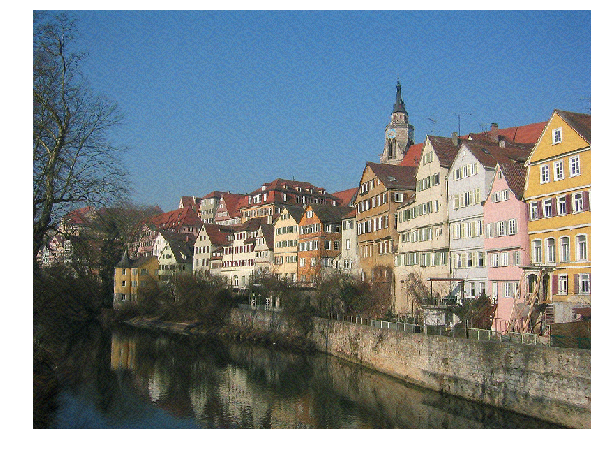

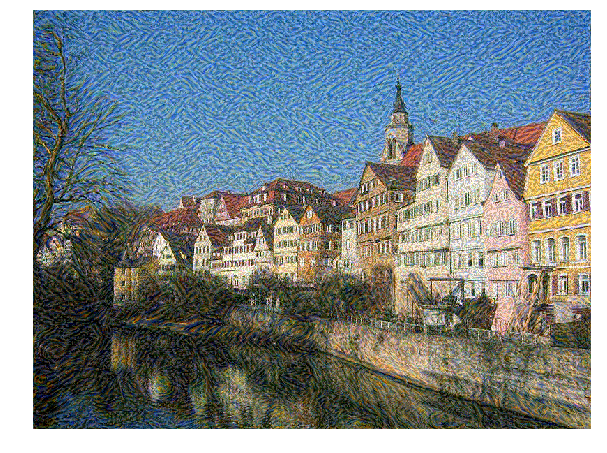

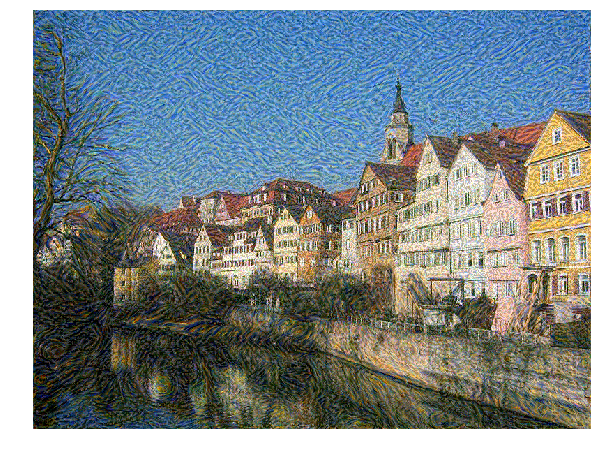

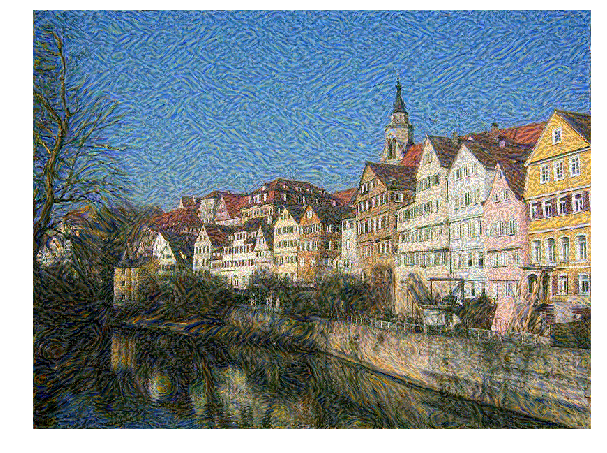

In [21]:
std_c=std_c.cuda()
mean_c=mean_c.cuda()
for i in range(100):
    loss=feat_loss.forward(x,content,style)
    loss.backward()
    print(loss)
    opt.step()
    opt.zero_grad()
    if i%30==0:
        with torch.no_grad():
            r=torch.clamp_min(x*std_c[...,None,None]+mean_c[...,None,None],0)
            r=torch.clamp_max(r,1)
            show_image(r,figsize=(10,10))